# Import Statements

In [3]:
import pandas as pd
import numpy as np

In [1]:
import badapy as bd
import scipy.signal as scs

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(rc={'figure.figsize':(10,10)})
plt.style.use('ggplot')
#sns.set_style('whitegrid')

# Load Data and Seperate Flights

In [4]:
data = pd.read_csv("./badapy/data/BADA_Test_652_CruiseFilter_Training.csv")
data.head()

,airspeed,temp,alt,rocd,ps,tat,fqty,ff
0,406.8750,-39.00,29023,48,9.290293,-17.25,13488,5496
1,407.4375,-39.00,29024,-16,9.291270,-17.25,13488,5496
2,408.2500,-39.00,29022,-208,9.292247,-17.25,13488,5496
3,408.8125,-39.25,29026,256,9.291270,-17.00,13488,5496
4,409.2500,-39.25,29022,-96,9.292247,-17.00,13488,5504


In [5]:
def seperate_flights(df):
    counter = 1
    df['flight'] = 0
    df.loc[0, 'flight'] = 1
    for i in range(1, df.shape[0]):
        if np.abs(df.loc[i ,'alt']-df.loc[i-1 ,'alt'])>50:
            counter += 1
            df.loc[i,'flight']= counter
        else:
            df.loc[i,'flight']= counter
    return df

In [6]:
added = seperate_flights(data)
added.tail()

,airspeed,temp,alt,rocd,ps,tat,fqty,ff,flight
20495,417.3125,-37.00,31003,16,8.490129,-14.25,9544,5072,183
20496,417.1250,-37.00,31002,-16,8.491107,-14.25,9544,5080,183
20497,417.1250,-37.00,31001,0,8.491107,-14.25,9544,5072,183
20498,417.0000,-37.25,31002,16,8.491107,-14.25,9544,5080,183
20499,417.0000,-37.25,31002,96,8.491107,-14.25,9544,5080,183


In [7]:
added['temp']=added['temp'].apply(lambda x: x + 273.15)
added['alt']=added['alt'].apply(lambda x: x * 0.3048)
added['rocd']=added['rocd'].apply(lambda x: x * 0.3048)
added['airspeed']=added['airspeed'].apply(lambda x: x * 0.514444)

# Create Airplane and Flight with updated Flightdata

In [8]:
test = bd.Airplane("B462", "Boeing") 
test.load_information("./badapy/data/")
trial_flight=bd.Flight("1234", "BLA", test) 

In [9]:
trial_flight.flightdata=added
trial_flight.flightdata.rocd = 0 
trial_flight.calculate_fuel() 
trial_flight.flightdata.current_fuel = trial_flight.flightdata.current_fuel.apply(lambda x: x * 132,277) 
trial_flight.flightdata['difference'] = trial_flight.flightdata.ff - trial_flight.flightdata.current_fuel 

nan


## Calculate averages per flight

In [10]:
avg_diff = []
cumsum_diff = []
length_flight = []
for i in range(1, max(added['flight']+1)):
    subset = trial_flight.flightdata[trial_flight.flightdata['flight'] == i]
    diff = subset['difference'].median()
    cum = subset['difference'][2:-2].sum()
    length_flight.append(subset.shape[0])
    avg_diff.append(diff)
    cumsum_diff.append(cum)
    print('Flight:{flight}, Difference:{diff:5.3f}, Difference Sum: {diff_sum: 5.3f}'  
          .format(flight = i, diff = diff, diff_sum = cum))

Flight:1, Difference:895.581, Difference Sum:  99466.550
Flight:2, Difference:1354.371, Difference Sum:  138954.002
Flight:3, Difference:2158.035, Difference Sum:  198449.758
Flight:4, Difference:-589.674, Difference Sum: -119694.522
Flight:5, Difference:1266.678, Difference Sum:  120443.689
Flight:6, Difference:1785.059, Difference Sum:  423679.229
Flight:7, Difference:898.305, Difference Sum:  82736.199
Flight:8, Difference:109.282, Difference Sum:  24870.280
Flight:9, Difference:1223.600, Difference Sum:  115734.864
Flight:10, Difference:-537.982, Difference Sum: -49891.645
Flight:11, Difference:944.950, Difference Sum:  99031.730
Flight:12, Difference:-309.697, Difference Sum:  53424.600
Flight:13, Difference:1200.271, Difference Sum:  114144.450
Flight:14, Difference:1417.472, Difference Sum:  152176.221
Flight:15, Difference:810.792, Difference Sum:  74458.726
Flight:16, Difference:141.874, Difference Sum:  4147.116
Flight:17, Difference:-770.858, Difference Sum: -74252.526
Fligh

In [11]:
np.array(avg_diff)[np.array(length_flight)>80].sum()/np.array(avg_diff)[np.array(length_flight)>80].shape[0]

603.9921813886165

In [12]:
np.median(np.array(avg_diff)[np.array(length_flight)>80])

602.1439525547337

In [13]:
np.array(cumsum_diff)[np.abs(np.array(cumsum_diff))<10000]

array([ 4147.11558548,  1016.52044723,  4925.94876117,  4151.05717025,
        4544.54813755,     0.        ,  9418.85814568,  1066.79300836,
        3627.26319077,  1208.78382995, -6810.24999486, -3901.00271905,
       -7122.42633807,  9207.43259325,  2199.48930147,  6733.83651854,
        1444.98752412,  9558.0803176 ,  5682.19025472])

# Create Plots

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


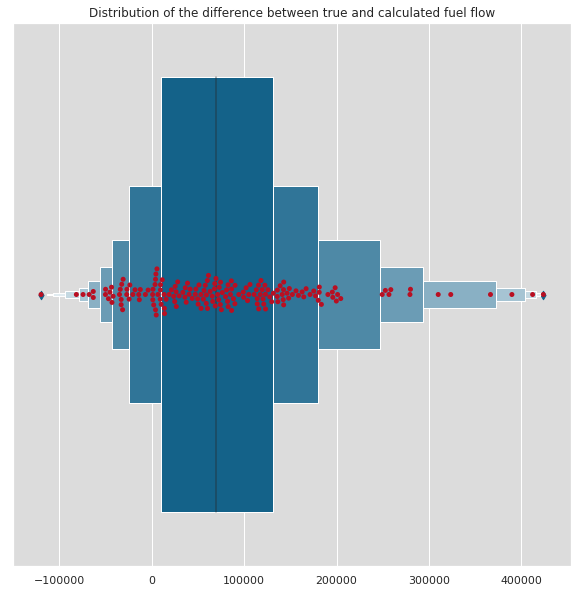

In [221]:
ae = sns.boxenplot(x = np.array(cumsum_diff)[np.array(length_flight)>80], color = '#00689D')
ae = sns.swarmplot(x = np.array(cumsum_diff)[np.array(length_flight)>80], color = '#b90f22')
ae.set_title('Distribution of the difference between true and calculated fuel flow')
ae.figure.savefig('total_diff.png')
ae.set_facecolor('#dcdcdc')

Text(0.5, 1.0, 'Distribution of the difference between true and calculated fuel flow')

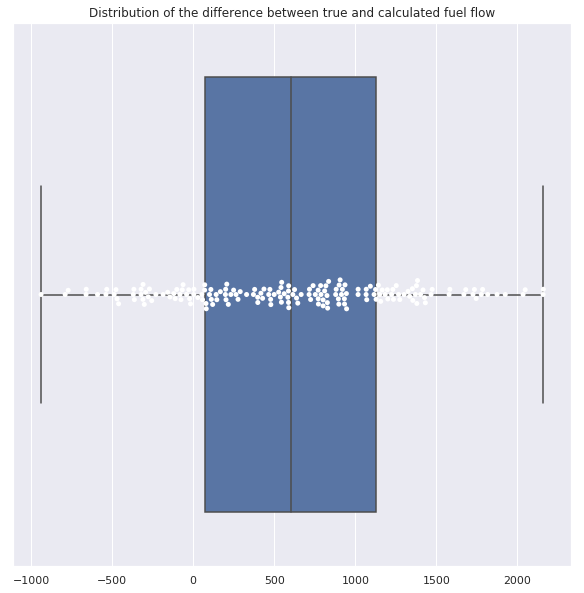

In [111]:
ax = sns.boxplot(x = np.array(avg_diff)[np.array(length_flight)>80])
ax = sns.swarmplot(x = np.array(avg_diff)[np.array(length_flight)>80], color = 'white')
ax.set_title('Distribution of the difference between true and calculated fuel flow')

In [14]:
avg_ff = []
avg_calcff = []
for i in range(1, max(added['flight']+1)):
    subset = trial_flight.flightdata[trial_flight.flightdata['flight'] == i]
    avg_ff.append(subset['ff'].mean())
    avg_calcff.append(subset['current_fuel'].median())

In [15]:
agg_data = pd.DataFrame({'FF': np.array(avg_ff), 'Calc_FF': np.array(avg_calcff)})
filter_data = agg_data['Calc_FF'] > -1000
agg_data[filter_data].shape

(182, 2)

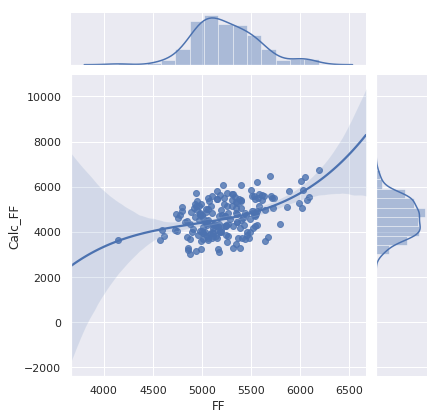

In [126]:
da = sns.jointplot("FF", "Calc_FF", data=agg_data[filter_data], 
                 kind = 'reg', order = 3)
#da.set_title('Jointplot with Regression - Calculated vs. True FF')

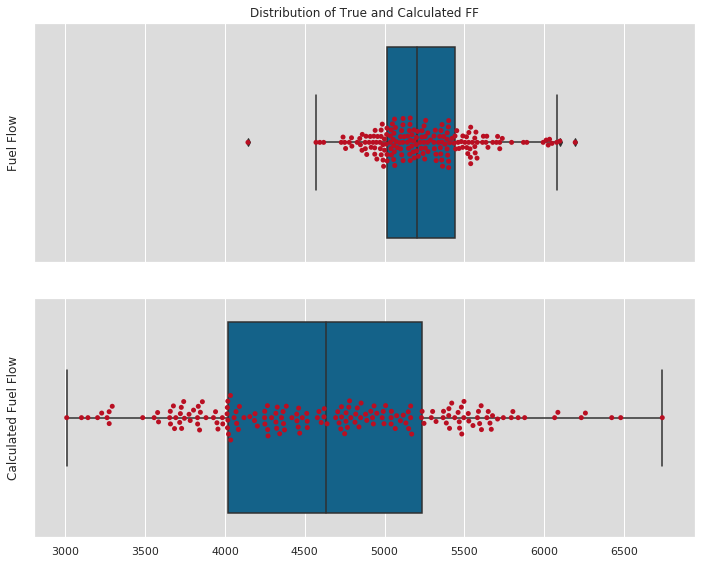

In [223]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
# plot 1
sns.boxplot(x = np.array(avg_ff), ax = ax1, color = '#00689D')
sns.swarmplot(x = np.array(avg_ff), color = '#b90f22', ax = ax1)
ax1.set_ylabel('Fuel Flow')
ax1.set_facecolor('#dcdcdc')


# plot 2
sns.boxplot(x = np.array(avg_calcff)[np.array(avg_calcff)> -1000], ax = ax2, color = '#00689D')
sns.swarmplot(x = np.array(avg_calcff)[np.array(avg_calcff)> -1000], color = '#b90f22', ax = ax2)
ax2.set_ylabel('Calculated Fuel Flow')
ax2.set_facecolor('#dcdcdc')

ax1.set_title('Distribution of True and Calculated FF')
plt.tight_layout(h_pad = 2)
plt.savefig('distribution.png')

In [47]:
trial_flight.flightdata[trial_flight.flightdata['flight'] == 80].shape

(100, 11)

### Flight 145

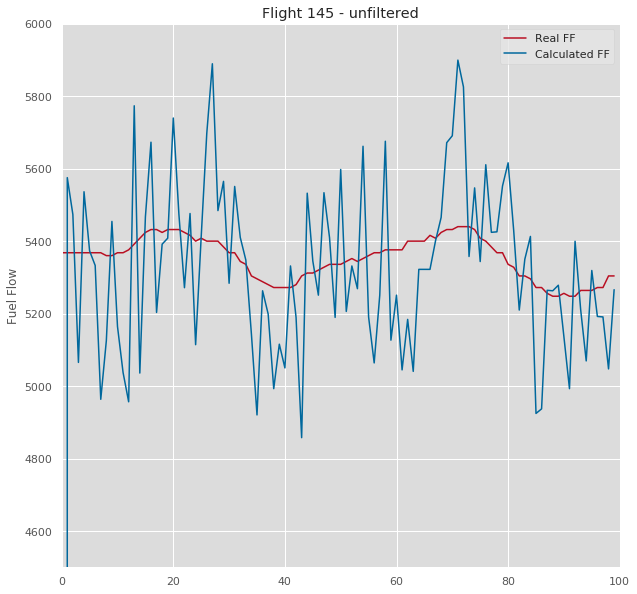

In [57]:
g = sns.lineplot(y = "ff", x = np.array(range(100)),
                 data = trial_flight.flightdata[trial_flight.flightdata['flight'] == 145],
                 color = '#b90f22', label = 'Real FF')
g = sns.lineplot(y = "current_fuel", x = np.array(range(100)),
                 data = trial_flight.flightdata[trial_flight.flightdata['flight'] == 145],
                 color = '#00689D', label = 'Calculated FF')
g.set_xlim(0,100)
g.set_ylim(4500,6000)
g.set_ylabel('Fuel Flow')
g.set_facecolor('#dcdcdc')
g.legend()
g.set_title('Flight 145 - unfiltered')
g.figure.savefig('unfiltered.png')

In [43]:
y_145 = trial_flight.flightdata['current_fuel'][trial_flight.flightdata['flight'] == 145].values
y_sav_145 = scs.savgol_filter(y_145, 11, 1)

In [44]:
y = trial_flight.flightdata['current_fuel'][trial_flight.flightdata['flight'] == 145].values
y_new = []

for i in range(5,y.shape[0]-3):
    y_new.append((y[i-3]+y[i-2]+y[i-1]+y[i]+y[i+1]+y[i+2]+y[i+3])/7)
np.array(y_new).shape[0]
np.sum(np.array(y_new)-trial_flight.flightdata[trial_flight.flightdata['flight'] == 145]['ff'].values[4:96])

-2169.303784315335

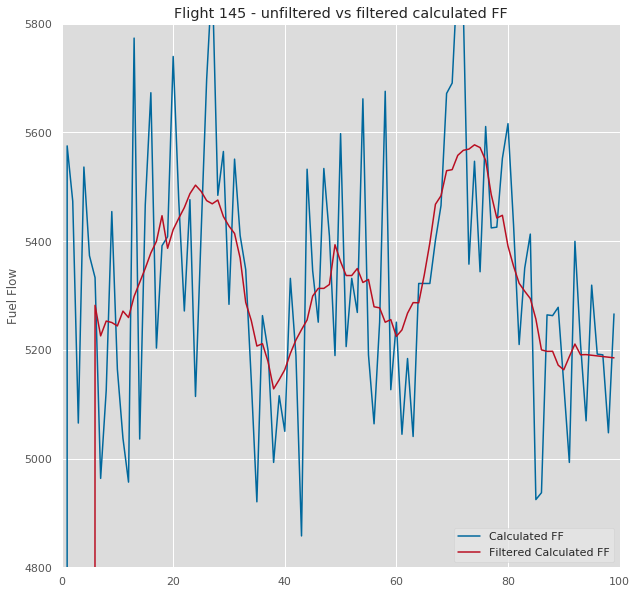

In [47]:
g = sns.lineplot(y = "current_fuel", x = np.array(range(100)),
                 data = trial_flight.flightdata[trial_flight.flightdata['flight'] == 145],
                 color = '#00689D', label = 'Calculated FF')
g = sns.lineplot(y = np.array(y_sav_145), x = np.array(range(100)),
                 color = '#b90f22', label = 'Filtered Calculated FF') 
g.set_xlim(0,100)
g.set_ylim(4800,5800)
g.set_ylabel('Fuel Flow')
g.set_facecolor('#dcdcdc')
g.legend()
g.set_title('Flight 145 - unfiltered vs filtered calculated FF') 
g.figure.savefig('calc_ff_comp.png')

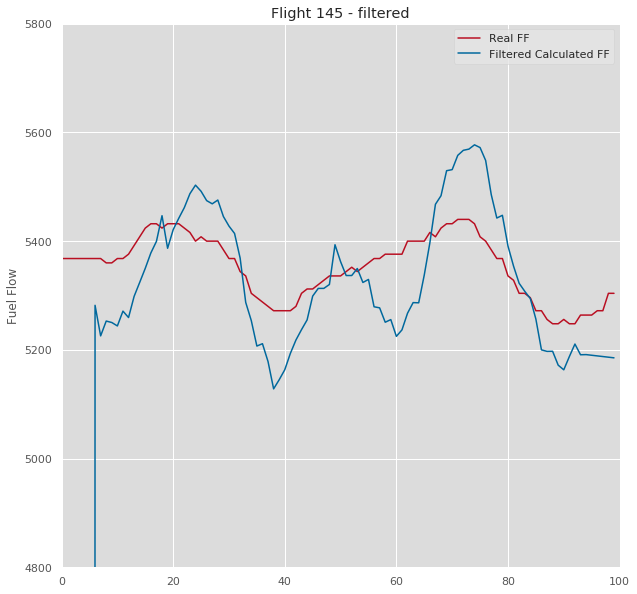

In [45]:
g = sns.lineplot(y = "ff", x = np.array(range(100)),
                 data = trial_flight.flightdata[trial_flight.flightdata['flight'] == 145],
                 color = '#b90f22', label = 'Real FF')
g = sns.lineplot(y = np.array(y_sav_145), x = np.array(range(100)),
                 color = '#00689D', label = 'Filtered Calculated FF')         
g.set_xlim(0,100)
g.set_ylim(4800,5800)
g.set_ylabel('Fuel Flow')
g.set_facecolor('#dcdcdc')
g.legend()
g.set_title('Flight 145 - filtered')
g.figure.savefig('filtered.png')


### Flight 121

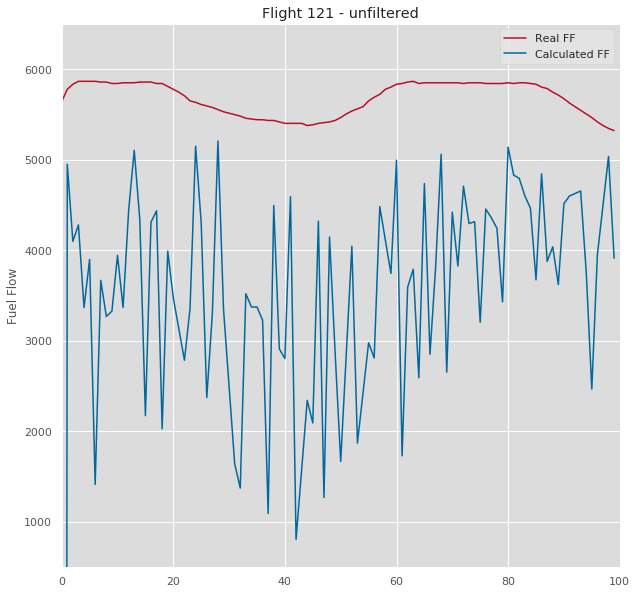

In [63]:
g = sns.lineplot(y = "ff", x = np.array(range(100)),
                 data = trial_flight.flightdata[trial_flight.flightdata['flight'] == 121],
                 color = '#b90f22', label = 'Real FF')
g = sns.lineplot(y = "current_fuel", x = np.array(range(100)),
                 data = trial_flight.flightdata[trial_flight.flightdata['flight'] == 121],
                 color = '#00689D', label = 'Calculated FF')
g.set_xlim(0,100)
g.set_ylim(500,6500)
g.set_ylabel('Fuel Flow')
g.set_facecolor('#dcdcdc')
g.legend()
g.set_title('Flight 121 - unfiltered')
g.figure.savefig('unfiltered_121.png')

In [30]:
y_121 = trial_flight.flightdata['current_fuel'][trial_flight.flightdata['flight'] == 121].values
y_new_121 = scs.savgol_filter(y_121, 9,1)

/home/krtim/.virtualenvs/master/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


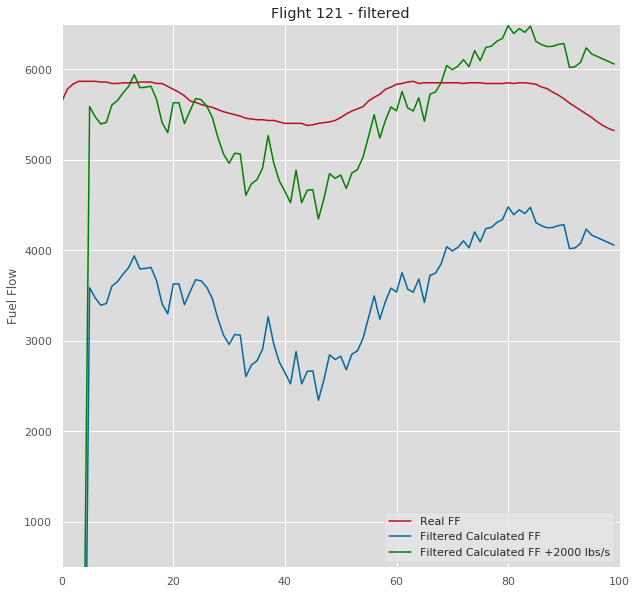

In [38]:
g = sns.lineplot(y = "ff", x = np.array(range(100)),
                 data = trial_flight.flightdata[trial_flight.flightdata['flight'] == 121],
                 color = '#b90f22', label = 'Real FF')
g = sns.lineplot(y = np.array(y_new_121), x = np.array(range(100)),
                 color = '#00689D', label = 'Filtered Calculated FF')
g = sns.lineplot(y = np.array(y_new_121)+2000, x = np.array(range(100)),
                 color = 'green', label = 'Filtered Calculated FF +2000 lbs/s')
g.set_xlim(0,100)
g.set_ylim(500,6500)
g.set_ylabel('Fuel Flow')
g.set_facecolor('#dcdcdc')
g.legend()
g.set_title('Flight 121 - filtered')
g.figure.savefig('filtered_121.png')

(3000, 7000)

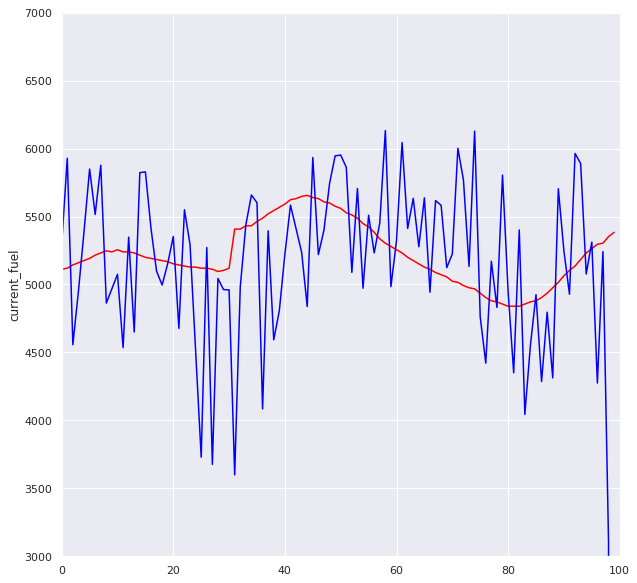

In [73]:
ca = sns.lineplot(y = "ff", x = np.array(range(100)), data = trial_flight.flightdata[trial_flight.flightdata['flight'] == 80], color = 'red')
ca = sns.lineplot(y = "current_fuel", x = np.array(range(100)), data = trial_flight.flightdata[trial_flight.flightdata['flight'] == 80], color = 'blue')
ca.set_xlim(0,100)
ca.set_ylim(3000,7000)

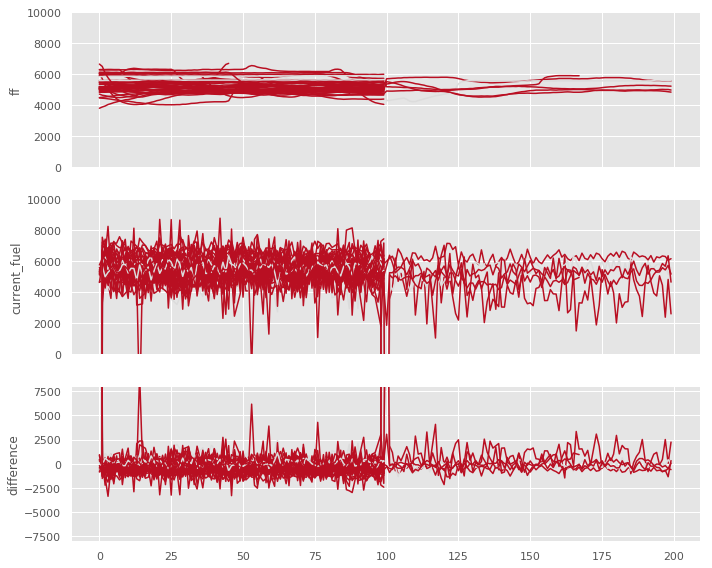

In [21]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
for i in range(max(trial_flight.flightdata['flight'])):
    if trial_flight.flightdata[trial_flight.flightdata['flight'] == i]['difference'].median() < 50:
        col = '#b90f22'
    elif trial_flight.flightdata[trial_flight.flightdata['flight'] == i]['difference'].median() < 100:
        col = '#dcdcdc'
    else:
        continue
    
    sns.lineplot(y = "ff", x = np.array(range(trial_flight.flightdata[trial_flight.flightdata['flight'] == i].shape[0])),
                 data = trial_flight.flightdata[trial_flight.flightdata['flight'] == i], ax = ax1, color = col)
    sns.lineplot(y = "current_fuel", x = np.array(range(trial_flight.flightdata[trial_flight.flightdata['flight'] == i].shape[0])),
                 data = trial_flight.flightdata[trial_flight.flightdata['flight'] == i], ax = ax2, color = col)
    sns.lineplot(y = "difference", x = np.array(range(trial_flight.flightdata[trial_flight.flightdata['flight'] == i].shape[0])),
                 data = trial_flight.flightdata[trial_flight.flightdata['flight'] == i], ax = ax3, color = col)
ax1.set_ylim(0,10000)    
ax2.set_ylim(0,10000)
ax3.set_ylim(-8000,8000)
plt.tight_layout(h_pad = 2)

In [22]:
length_of_segments = []
for i in range(max(trial_flight.flightdata['flight'])):
    length_of_segments.append(trial_flight.flightdata[trial_flight.flightdata['flight'] == i].shape[0])


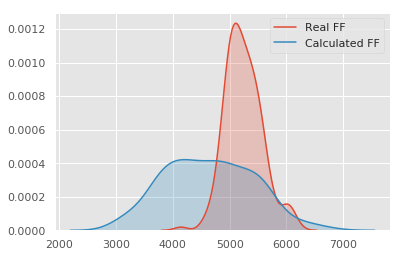

In [39]:
sns.kdeplot(np.array(avg_ff)[np.array(avg_ff)>0], shade = True, label = 'Real FF')
sns.kdeplot(np.array(avg_calcff)[np.array(avg_calcff)>0], shade = True, label = 'Calculated FF')
plt.legend()

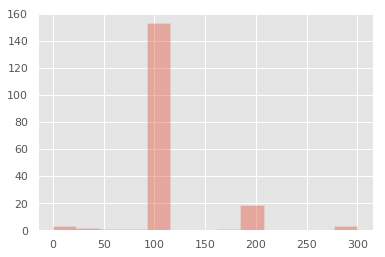

In [25]:
sns.distplot(np.array(length_of_segments), kde = False)